## **Import Dependencies**

In [253]:
import os
import pickle
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as ts

from tqdm import tqdm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests

from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## **Read the Dataset**

In [254]:
data = pd.read_csv("/content/ASII.csv")

column_to_drop = ["previous", "open_price", "first_trade", "high", "low", "delisting_date"]
data = data.drop(column_to_drop, axis=1)
data.head()

,date,close,change,volume,value,frequency,index_individual,offer,offer_volume,bid,bid_volume,listed_shares,tradeble_shares,weight_for_index,foreign_sell,foreign_buy,non_regular_volume,non_regular_value,non_regular_frequency
0,2019-07-29T00:00:00,7175.0,100.0,18841000.0,1.344756e+11,3859.0,5131.0,7175.0,633400.0,7150.0,1600.0,4.048355e+10,4.048355e+10,4.048355e+10,12745600.0,9583800.0,2808700.0,1.995158e+10,7.0
1,2019-07-30T00:00:00,7275.0,100.0,30765800.0,2.220982e+11,4420.0,5202.5,7275.0,1122400.0,7225.0,162000.0,4.048355e+10,4.048355e+10,4.048355e+10,17320100.0,15540300.0,4249420.0,3.027105e+10,25.0
2,2019-07-31T00:00:00,7000.0,-275.0,61515300.0,4.324626e+11,11015.0,5005.8,7025.0,110200.0,7000.0,6532400.0,4.048355e+10,4.048355e+10,4.048355e+10,50801800.0,16316900.0,54680952.0,3.850957e+11,45.0
3,2019-08-01T00:00:00,7025.0,25.0,37270900.0,2.619394e+11,5176.0,5023.7,7050.0,514800.0,7025.0,2984200.0,4.048355e+10,4.048355e+10,4.048355e+10,25471600.0,27668200.0,31364378.0,2.208941e+11,19.0
4,2019-08-02T00:00:00,7075.0,50.0,40942800.0,2.884855e+11,5182.0,5059.5,7100.0,3721700.0,7075.0,700.0,4.048355e+10,4.048355e+10,4.048355e+10,26615000.0,27470700.0,14526329.0,1.030492e+11,13.0


## **Understanding the Dataset**

In [255]:
# Check the percentage of Nan in dataset
total        = data.isnull().sum().sort_values(ascending=False)
percent      = (data.isnull().sum() / len(data)).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(15)

,Total,Percent
date,0,0.0
bid_volume,0,0.0
non_regular_value,0,0.0
non_regular_volume,0,0.0
foreign_buy,0,0.0
foreign_sell,0,0.0
weight_for_index,0,0.0
tradeble_shares,0,0.0
listed_shares,0,0.0
bid,0,0.0


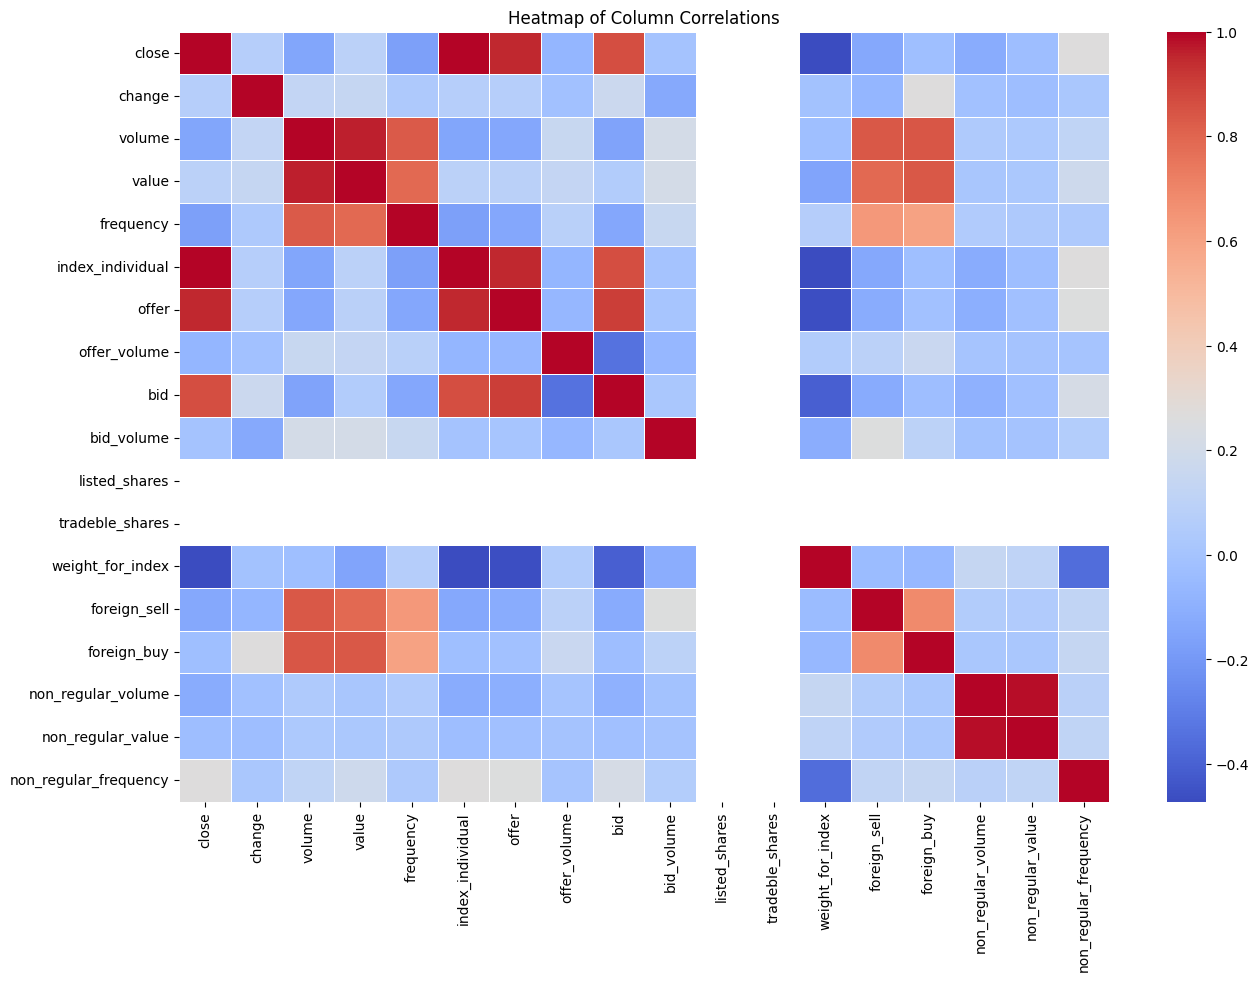

In [256]:
def visualize_heatmap(data):
    """
    Visualize a heatmap of the correlation matrix for the DataFrame.

    Parameters:
    - data (pd.DataFrame): The DataFrame for which the heatmap is generated.

    Returns:
    None
    """
    # Calculate the correlation matrix
    correlation_matrix = data.corr()

    # Set the size of the figure
    plt.figure(figsize=(15, 10))

    # Display the heatmap
    sns.heatmap(correlation_matrix, cmap='coolwarm', fmt='.2f', linewidths=0.5)

    # Adjust the layout
    plt.title('Heatmap of Column Correlations')
    plt.show()

# Call the function to display the heatmap
visualize_heatmap(data)

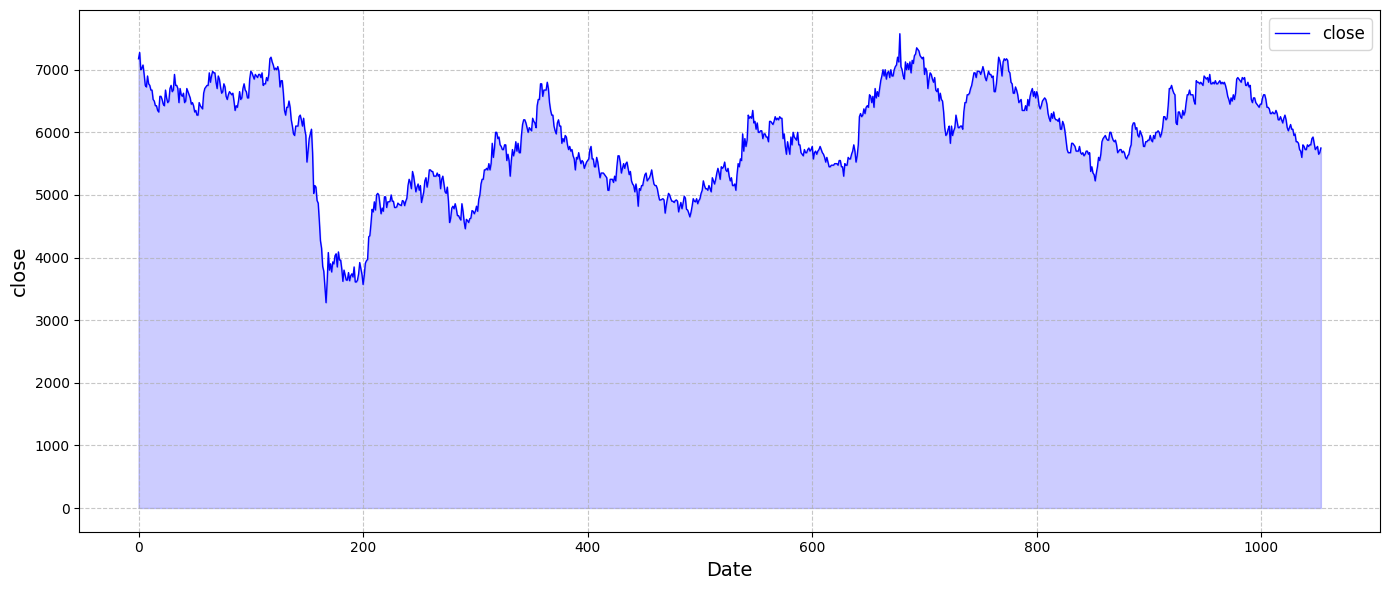

In [257]:
def visualize_timeframe(data, target_column="close"):
    """
    Visualize the target column using a line chart with fill between.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - target_column (str, optional): The column to visualize. Default is target.

    Returns:
    None
    """
    # Set the size of the figure
    plt.figure(figsize=(14, 6))

    # Create a line chart for target
    plt.plot(data.index, data[target_column], label=target_column, color='blue', linestyle='-', linewidth=1)

    # Add fill between the line and the x-axis
    plt.fill_between(data.index, data[target_column], color='blue', alpha=0.2)

    # Add labels and title
    plt.xlabel('Date', fontsize=14)
    plt.ylabel(target_column, fontsize=14)

    # Add a legend
    plt.legend(fontsize=12)

    # Add a grid
    plt.grid(True, linestyle='--', alpha=0.7)

    # Adjust the layout
    plt.tight_layout()
    plt.show()

# Visualize the close price
visualize_timeframe(data)

## **Preprocessing the Dataset**

In [258]:
# Mengonversi kolom 'date' menjadi tipe data datetime
data['date'] = pd.to_datetime(data['date'])

# Menjadikan kolom 'date' sebagai indeks
data.set_index('date', inplace=True)
data.head()

,close,change,volume,value,frequency,index_individual,offer,offer_volume,bid,bid_volume,listed_shares,tradeble_shares,weight_for_index,foreign_sell,foreign_buy,non_regular_volume,non_regular_value,non_regular_frequency
date,,,,,,,,,,,,,,,,,,
2019-07-29,7175.0,100.0,18841000.0,1.344756e+11,3859.0,5131.0,7175.0,633400.0,7150.0,1600.0,4.048355e+10,4.048355e+10,4.048355e+10,12745600.0,9583800.0,2808700.0,1.995158e+10,7.0
2019-07-30,7275.0,100.0,30765800.0,2.220982e+11,4420.0,5202.5,7275.0,1122400.0,7225.0,162000.0,4.048355e+10,4.048355e+10,4.048355e+10,17320100.0,15540300.0,4249420.0,3.027105e+10,25.0
2019-07-31,7000.0,-275.0,61515300.0,4.324626e+11,11015.0,5005.8,7025.0,110200.0,7000.0,6532400.0,4.048355e+10,4.048355e+10,4.048355e+10,50801800.0,16316900.0,54680952.0,3.850957e+11,45.0
2019-08-01,7025.0,25.0,37270900.0,2.619394e+11,5176.0,5023.7,7050.0,514800.0,7025.0,2984200.0,4.048355e+10,4.048355e+10,4.048355e+10,25471600.0,27668200.0,31364378.0,2.208941e+11,19.0
2019-08-02,7075.0,50.0,40942800.0,2.884855e+11,5182.0,5059.5,7100.0,3721700.0,7075.0,700.0,4.048355e+10,4.048355e+10,4.048355e+10,26615000.0,27470700.0,14526329.0,1.030492e+11,13.0


In [259]:
# Inisialisasi MinMaxScaler
scaler = MinMaxScaler()

# Mengambil kolom yang akan dinormalisasi
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Melakukan normalisasi untuk kolom-kolom numerik
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])
data.head()

,close,change,volume,value,frequency,index_individual,offer,offer_volume,bid,bid_volume,listed_shares,tradeble_shares,weight_for_index,foreign_sell,foreign_buy,non_regular_volume,non_regular_value,non_regular_frequency
date,,,,,,,,,,,,,,,,,,
2019-07-29,0.906868,0.675676,0.037468,0.053083,0.062591,0.906883,0.944079,0.019541,0.943894,0.000039,0.0,0.0,1.0,0.065525,0.050705,0.014953,0.020619,0.067961
2019-07-30,0.930151,0.675676,0.076701,0.107481,0.074587,0.930162,0.957237,0.034627,0.953795,0.003917,0.0,0.0,1.0,0.089288,0.086421,0.022623,0.031283,0.242718
2019-07-31,0.866123,0.337838,0.177867,0.238080,0.215615,0.866120,0.924342,0.003400,0.924092,0.157955,0.0,0.0,1.0,0.263219,0.091078,0.291106,0.397970,0.436893
2019-08-01,0.871944,0.608108,0.098103,0.132215,0.090754,0.871948,0.927632,0.015882,0.927393,0.072159,0.0,0.0,1.0,0.131634,0.159143,0.166975,0.228279,0.184466
2019-08-02,0.883586,0.630631,0.110184,0.148696,0.090882,0.883604,0.934211,0.114817,0.933993,0.000017,0.0,0.0,1.0,0.137574,0.157959,0.077334,0.106494,0.126214


## **Select Target Column**

In [260]:
data_close = data[['close']]
data_close.head()

,close
date,
2019-07-29,0.906868
2019-07-30,0.930151
2019-07-31,0.866123
2019-08-01,0.871944
2019-08-02,0.883586


## **Windowing the Dataset**

In [261]:
# Menentukan jumlah lag yang diinginkan
num_lags = 10

# Membuat kolom-kolom yang merupakan lag dari kolom 'close'
for i in range(1, num_lags + 1):
    data_close[f'lag_{i}'] = data_close['close'].shift(i)
data_close = data_close.dropna()
data_close.head()

,close,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
date,,,,,,,,,,,
2019-08-12,0.807916,0.813737,0.842841,0.802095,0.807916,0.848661,0.883586,0.871944,0.866123,0.930151,0.906868
2019-08-13,0.790454,0.807916,0.813737,0.842841,0.802095,0.807916,0.848661,0.883586,0.871944,0.866123,0.930151
2019-08-14,0.790454,0.790454,0.807916,0.813737,0.842841,0.802095,0.807916,0.848661,0.883586,0.871944,0.866123
2019-08-15,0.755530,0.790454,0.790454,0.807916,0.813737,0.842841,0.802095,0.807916,0.848661,0.883586,0.871944
2019-08-16,0.749709,0.755530,0.790454,0.790454,0.807916,0.813737,0.842841,0.802095,0.807916,0.848661,0.883586


## **Split the Dataset**

In [230]:
data_train = data_close[:int(0.8*len(data))]
data_test  = data_close[int(0.8*len(data)):]

print("Data train shape :", data_train.shape)
print("Data test shape  :", data_test.shape)

Data train shape : (843, 11)
Data test shape  : (201, 11)


In [231]:
X_train = data_train.iloc[:, 1:]
y_train = data_train.iloc[:,0]

X_test = data_test.iloc[:, 1:]
y_test = data_test.iloc[:,0]

## **Build Model Architecture**

In [232]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, return_sequences=False, input_shape=(X_train.shape[1], 1)))
model.add(tf.keras.layers.Dense(1))
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 128)               66560     
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 66689 (260.50 KB)
Trainable params: 66689 (260.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## **Train the Model**

In [233]:
# Mengkompilasi model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

# Membuat callback untuk menyimpan model berdasarkan MSE terkecil
checkpoint = ModelCheckpoint('ASII.h5', monitor='val_mse', mode='min', save_best_only=True, verbose=1)

# Melatih model dengan menggunakan callback ModelCheckpoint
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[checkpoint])

Epoch 1/100
25/27 [==========================>...] - ETA: 0s - loss: 0.0557 - mse: 0.0557
Epoch 1: val_mse improved from inf to 0.00857, saving model to ASII.h5
27/27 [==============================] - 4s 39ms/step - loss: 0.0533 - mse: 0.0533 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 2/100
24/27 [=========================>....] - ETA: 0s - loss: 0.0051 - mse: 0.0051
Epoch 2: val_mse improved from 0.00857 to 0.00187, saving model to ASII.h5
27/27 [==============================] - 1s 19ms/step - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 3/100
25/27 [==========================>...] - ETA: 0s - loss: 0.0039 - mse: 0.0039
Epoch 3: val_mse did not improve from 0.00187
27/27 [==============================] - 1s 19ms/step - loss: 0.0038 - mse: 0.0038 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 4/100
25/27 [==========================>...] - ETA: 0s - loss: 0.0035 - mse: 0.0035
Epoch 4: val_mse did not improve from 0.00187
27/27 [==============================] - 0

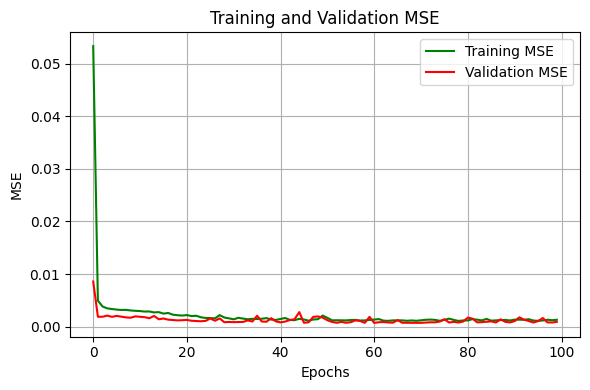

In [242]:
# Memvisualisasikan metrik MSE pelatihan dan validasi dengan kombinasi garis dan titik
plt.figure(figsize=(6, 4))
plt.plot(history.history['mse'], linestyle='-', label='Training MSE', color='green')
plt.plot(history.history['val_mse'], linestyle='-', label='Validation MSE', color='red')

plt.title('Training and Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')

plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

## **Model Performance on Test Set**

In [235]:
y_test_pred = model.predict(X_test)
y_test_pred

7/7 [==============================] - 0s 6ms/step


array([[0.46758282],
       [0.46914926],
       [0.48437703],
       [0.5134856 ],
       [0.530235  ],
       [0.55216223],
       [0.58503413],
       [0.6124454 ],
       [0.6311452 ],
       [0.64362097],
       [0.64337677],
       [0.6380698 ],
       [0.631915  ],
       [0.63923985],
       [0.64348584],
       [0.6391058 ],
       [0.6316932 ],
       [0.62355113],
       [0.62000066],
       [0.610347  ],
       [0.5905061 ],
       [0.5789054 ],
       [0.5744633 ],
       [0.5740567 ],
       [0.5703648 ],
       [0.5709179 ],
       [0.56956977],
       [0.56142104],
       [0.5534311 ],
       [0.55281496],
       [0.55502295],
       [0.56799036],
       [0.5834692 ],
       [0.6249433 ],
       [0.6591634 ],
       [0.68214375],
       [0.68584734],
       [0.68634754],
       [0.6707296 ],
       [0.65401   ],
       [0.65010613],
       [0.6433466 ],
       [0.6340236 ],
       [0.61538786],
       [0.6026936 ],
       [0.602391  ],
       [0.6030791 ],
       [0.607

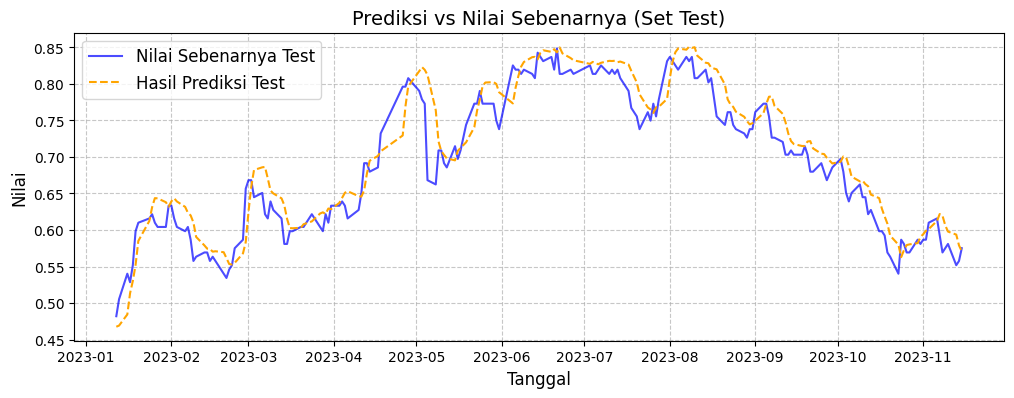

In [236]:
def plot_prediction(y_true, y_pred, dataset_name):
    """
    Plot hasil prediksi dan nilai sebenarnya.

    Parameters:
    - y_true (pandas.Series): Seri nilai sebenarnya.
    - y_pred (pandas.Series): Seri hasil prediksi.
    - dataset_name (str): Nama dataset (contoh: 'Validasi' atau 'Test').

    Returns:
    - None
    """
    plt.figure(figsize=(12, 4))

    # Plot nilai sebenarnya
    plt.plot(y_true.index, y_true, label=f'Nilai Sebenarnya {dataset_name}', color='blue', alpha=0.7)

    # Plot hasil prediksi
    plt.plot(y_true.index, y_pred, label=f'Hasil Prediksi {dataset_name}', linestyle='--', color='orange')

    # Menambahkan judul dan label
    plt.title(f'Prediksi vs Nilai Sebenarnya (Set {dataset_name})', fontsize=14)
    plt.xlabel('Tanggal', fontsize=12)
    plt.ylabel('Nilai', fontsize=12)

    # Menambahkan legenda
    plt.legend(fontsize=12)

    # Menambahkan grid
    plt.grid(True, linestyle='--', alpha=0.7)

    # Menampilkan plot
    plt.show()


# Panggil fungsi plot_prediction untuk set test
plot_prediction(y_test, y_test_pred, 'Test')

## **Save and Load Model**

In [250]:
# Simpan model setelah pelatihan
model.save('ASII.h5')

# Memuat kembali model yang telah disimpan
model = load_model('ASII.h5')

## **Forecast the Future**

In [262]:
# Perulangan untuk memprediksi masa depan
steps = 100

for i in range(steps):
    # Mendapatkan indeks baru untuk baris yang akan ditambahkan
    new_dex = data_close.index[-1] + pd.DateOffset(days=1)

    # Membuat DataFrame baru dengan nilai NaN di kolom pertama dan nilai dari baris terakhir di kolom lainnya
    new_row = pd.DataFrame(
        [[np.nan, data_close['close'].iloc[-1], data_close['lag_1'].iloc[-1], data_close['lag_2'].iloc[-1],
          data_close['lag_3'].iloc[-1], data_close['lag_4'].iloc[-1], data_close['lag_5'].iloc[-1],
          data_close['lag_6'].iloc[-1], data_close['lag_7'].iloc[-1], data_close['lag_8'].iloc[-1], data_close['lag_9'].iloc[-1]]],
        columns=data_close.columns,
        index=[new_dex]
    )

    # Menambahkan baris baru ke DataFrame
    data_close = data_close.append(new_row)

    # Melakukan prediksi dengan model untuk mengisi nilai NaN
    forecast = model.predict(data_close.iloc[[-1]].drop(columns=['close']))
    data_close = data_close.fillna(forecast[0][0])

1/1 [==============================] - 0s 27ms/step


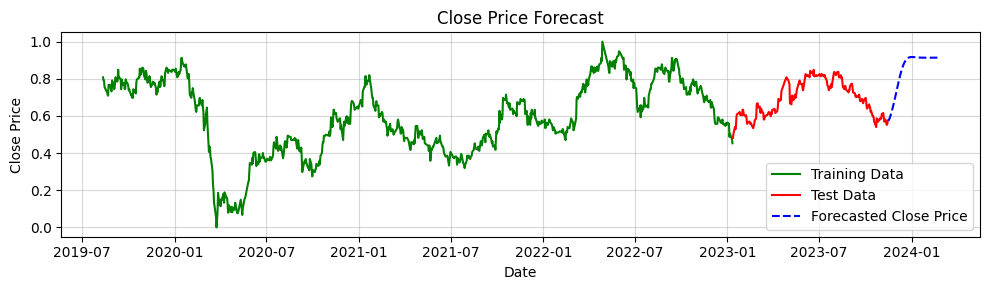

In [273]:
# Memilih 365 baris terakhir dari kolom 'close'
historical = data_close[['close']].iloc[-730-steps:-steps]
forecast = data_close[['close']].iloc[-steps:]

# Membuat plot untuk visualisasi data 'close'
plt.figure(figsize=(10, 3))

# Plot garis untuk data historis
plt.plot(data_train.index    , data_train['close']   , label='Training Data', color='green')
plt.plot(data_test.index     , data_test['close']    , label='Test Data'    , color='red')

# Plot garis untuk forecast dengan garis putus-putus
plt.plot(forecast.index, forecast['close'], label='Forecasted Close Price', color='blue', linestyle="--")

# Menambahkan judul dan label sumbu
plt.title('Close Price Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True, alpha=0.5, zorder=10)
plt.tight_layout()

# Menampilkan plot
plt.show()